In [ ]:
data_dir = '/content/drive/MyDrive/SENets/data/kaggle_cifar10_tiny/'

In [ ]:
import os
import shutil
import collections
import math
import pandas as pd
import torch
import torchvision
from torch import nn

def read_csv_labels(fname):
    """读取fname来给标签字典返回⼀个⽂件名"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

def copyfile(filename, target_dir):
    """将⽂件复制到⽬标⽬录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """Split the validation set out of the original training set.

    Defined in :numref:`sec_kaggle_cifar10`"""
    # The number of examples of the class that has the fewest examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction.
    Defined in :numref:`sec_kaggle_cifar10`"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file), os.path.join(data_dir, 'train_valid_test', 'test','unknown'))

def reorg_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)


In [ ]:
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

nn_Module = nn.Module

#################   WARNING   ################
# The below part is generated automatically through:
#    d2lbook build lib
# Don't edit it directly

import time
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn


def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

ones = torch.ones
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
rand = torch.rand
matmul = torch.matmul
int32 = torch.int32
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
eye = torch.eye
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)


In [ ]:
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

nn_Module = nn.Module

#################   WARNING   ################
# The below part is generated automatically through:
#    d2lbook build lib
# Don't edit it directly

import time
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn


def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    pass

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

ones = torch.ones
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
rand = torch.rand
matmul = torch.matmul
int32 = torch.int32
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
eye = torch.eye
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)


In [ ]:
import torch
import torch.nn as nn

class DyReLU(nn.Module):
    def __init__(self, channels, reduction=4, k=2, conv_type='2d'):
        super(DyReLU, self).__init__()
        self.channels = channels
        self.k = k
        self.conv_type = conv_type
        assert self.conv_type in ['1d', '2d']

        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, 2*k)
        self.sigmoid = nn.Sigmoid()

        self.register_buffer('lambdas', torch.Tensor([1.]*k + [0.5]*k).float())
        self.register_buffer('init_v', torch.Tensor([1.] + [0.]*(2*k - 1)).float())

    def get_relu_coefs(self, x):
        theta = torch.mean(x, axis=-1)
        if self.conv_type == '2d':
            theta = torch.mean(theta, axis=-1)
        theta = self.fc1(theta)
        theta = self.relu(theta)
        theta = self.fc2(theta)
        theta = 2 * self.sigmoid(theta) - 1
        return theta

    def forward(self, x):
        raise NotImplementedError


class DyReLUA(DyReLU):
    def __init__(self, channels, reduction=4, k=2, conv_type='2d'):
        super(DyReLUA, self).__init__(channels, reduction, k, conv_type)
        self.fc2 = nn.Linear(channels // reduction, 2*k)

    def forward(self, x):
        assert x.shape[1] == self.channels
        theta = self.get_relu_coefs(x)

        relu_coefs = theta.view(-1, 2*self.k) * self.lambdas + self.init_v
        # BxCxL -> LxCxBx1
        x_perm = x.transpose(0, -1).unsqueeze(-1)
        output = x_perm * relu_coefs[:, :self.k] + relu_coefs[:, self.k:]
        # LxCxBx2 -> BxCxL
        result = torch.max(output, dim=-1)[0].transpose(0, -1)

        return result


class DyReLUB(DyReLU):
    def __init__(self, channels, reduction=4, k=2, conv_type='2d'):
        super(DyReLUB, self).__init__(channels, reduction, k, conv_type)
        self.fc2 = nn.Linear(channels // reduction, 2*k*channels)

    def forward(self, x):
        assert x.shape[1] == self.channels
        theta = self.get_relu_coefs(x)

        relu_coefs = theta.view(-1, self.channels, 2*self.k) * self.lambdas + self.init_v

        if self.conv_type == '1d':
            # BxCxL -> LxBxCx1
            x_perm = x.permute(2, 0, 1).unsqueeze(-1)
            output = x_perm * relu_coefs[:, :, :self.k] + relu_coefs[:, :, self.k:]
            # LxBxCx2 -> BxCxL
            result = torch.max(output, dim=-1)[0].permute(1, 2, 0)

        elif self.conv_type == '2d':
            # BxCxHxW -> HxWxBxCx1
            x_perm = x.permute(2, 3, 0, 1).unsqueeze(-1)
            output = x_perm * relu_coefs[:, :, :self.k] + relu_coefs[:, :, self.k:]
            # HxWxBxCx2 -> BxCxHxW
            result = torch.max(output, dim=-1)[0].permute(2, 3, 0, 1)

        return result


In [ ]:
from torch.nn import init
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import math


class Maxout(nn.Module):
    __constants__ = ['bias']

    def __init__(self, in_features, out_features, pieces, bias=True):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.pieces = pieces
        self.weight = Parameter(torch.Tensor(pieces, out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(pieces, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        output = input.matmul(self.weight.permute(0, 2, 1)).permute((1, 0, 2)) + self.bias
        output = torch.max(output, dim=1)[0]
        return output

In [ ]:
import torchvision

# 调用torchvision自带的resnet模型用作对比
def resnet_18():
    return torchvision.models.resnet18(pretrained=False)


def resnet_50():
    return torchvision.models.resnet50(pretrained=False)


In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes, out_features=round(planes / 16))
        self.fc2 = nn.Linear(in_features=round(planes / 16), out_features=planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes * 4, out_features=round(planes / 4))
        self.fc2 = nn.Linear(in_features=round(planes / 4), out_features=planes * 4)
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
     
        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # print(x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print(x.size())
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.size())
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
       #  print(x.size())
       #  print("ok")
        return x


def se_resnet_18(pretrained=False, **kwargs):
    model = SENet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def se_resnet_34(pretrained=False, **kwargs):
    model = SENet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def se_resnet_50(pretrained=False, **kwargs):
    model = SENet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnet_101(pretrained=False, **kwargs):
    model = SENet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnet_152(pretrained=False, **kwargs):
    model = SENet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock_idea1(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_idea1, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dyrelu1 = DyReLUB(planes)
        self.dyrelu2 = DyReLUB(round(planes / 16))
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes, out_features=round(planes / 16))
        self.fc2 = nn.Linear(in_features=round(planes / 16), out_features=planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dyrelu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = out.view(out.size(0),out.size(1) , 1, 1)
        out = self.dyrelu2(out)
        out = out.view(out.size(0), -1)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_idea1(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_idea1, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.dyrelu1 = DyReLUB(planes)
        self.dyrelu2 = DyReLUB(round(planes / 16))
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes * 4, out_features=round(planes / 4))
        self.fc2 = nn.Linear(in_features=round(planes / 4), out_features=planes * 4)
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dyrelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dyrelu1(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = self.dyrelu2(out)
        out = out.view(out.size(0), -1)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet_idea1(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet_idea1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def se_resnet_18_idea1( **kwargs):
    model = SENet_idea1(BasicBlock_idea1, [2, 2, 2, 2], **kwargs)
    return model

def se_resnet_50_idea1( **kwargs):
    model = SENet_idea1(Bottleneck_idea1, [3, 4, 6, 3], **kwargs)
    return model


In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock_idea2(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_idea2, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.seconv = nn.Conv1d(planes,planes,kernel_size=5,padding=2)
        # 设置一个静态的一维卷积层seconv
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = self.seconv(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_idea2(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_idea2, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)

        self.seconv = nn.Conv1d(planes,planes,kernel_size=5,padding=2)
        # 设置一个静态的一维卷积层seconv
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = self.seconv(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet_idea2(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet_idea2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def se_resnet_18_idea2( **kwargs):
    model = SENet_idea2(BasicBlock_idea2, [2, 2, 2, 2], **kwargs)
    return model

def se_resnet_50_idea2( **kwargs):
    model = SENet_idea2(Bottleneck_idea2, [3, 4, 6, 3], **kwargs)
    return model



In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock_idea3(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_idea3, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.seconv1 = nn.Conv1d(planes,planes,kernel_size=5,padding=2)
        self.seconv2 = nn.Conv1d(planes, planes, kernel_size=5, padding=2)
        # 设置两个个静态的一维卷积层seconv
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = self.seconv1(out)
        out = self.relu(out)
        out = self.seconv2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_idea3(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_idea3, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)

        self.seconv1 = nn.Conv1d(planes,planes,kernel_size=5,padding=2)
        self.seconv2 = nn.Conv1d(planes, planes, kernel_size=5, padding=2)
        # 设置二个静态的一维卷积层seconv
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = self.seconv1(out)
        out = self.relu()
        out = self.seconv2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet_idea3(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet_idea3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def se_resnet_18_idea3( **kwargs):
    model = SENet_idea3(BasicBlock_idea3, [2, 2, 2, 2], **kwargs)
    return model

def se_resnet_50_idea3( **kwargs):
    model = SENet_idea3(Bottleneck_idea3, [3, 4, 6, 3], **kwargs)
    return model

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock_idea4(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_idea4, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalMaxPool = nn.MaxPool2d(56, stride=1)
        elif planes == 128:
            self.globalMaxPool = nn.MaxPool2d(28, stride=1)
        elif planes == 256:
            self.globalMaxPool = nn.MaxPool2d(14, stride=1)
        elif planes == 512:
            self.globalMaxPool = nn.MaxPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes, out_features=round(planes / 16))
        self.fc2 = nn.Linear(in_features=round(planes / 16), out_features=planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalMaxPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_idea4(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_idea4, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        if planes == 64:
            self.globalMaxPool = nn.MaxPool2d(56, stride=1)
        elif planes == 128:
            self.globalMaxPool = nn.MaxPool2d(28, stride=1)
        elif planes == 256:
            self.globalMaxPool = nn.MaxPool2d(14, stride=1)
        elif planes == 512:
            self.globalMaxPool = nn.MaxPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes * 4, out_features=round(planes / 4))
        self.fc2 = nn.Linear(in_features=round(planes / 4), out_features=planes * 4)
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalMaxPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet_idea4(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet_idea4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.Maxpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.Maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def se_resnet_18_idea4(**kwargs):
    model = SENet_idea4(BasicBlock_idea4, [2, 2, 2, 2], **kwargs)
    return model

def se_resnet_50_idea4(**kwargs):
    model = SENet_idea4(Bottleneck_idea4, [3, 4, 6, 3], **kwargs)
    return model

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock_idea5(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_idea5, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.sigmoid = nn.Sigmoid()
        self.maxout1 = Maxout(in_features=planes, out_features=round(planes / 16), pieces=10)
        self.maxout2 = Maxout(in_features=round(planes / 16), out_features=planes,pieces=10)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.maxout1(out)
        out = self.relu(out)
        out = self.maxout2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out

class SENet_idea5(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SENet_idea5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def se_resnet_18_idea5(**kwargs):
    model = SENet_idea5(BasicBlock_idea5, [2, 2, 2, 2], **kwargs)
    return model


epoch : 99
train loss 0.008, train acc 1.000, valid acc 0.870
930.0 examples/sec on [device(type='cuda', index=0)]


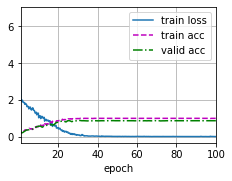

In [ ]:
import torchvision
import torch
import os
import matplotlib.pyplot as plt
from torch import nn

batch_size = 32
valid_ratio = 0.1

reorg_data(data_dir, valid_ratio)

transform_train = torchvision.transforms.Compose([
torchvision.transforms.Resize([224,224]),
torchvision.transforms.RandomHorizontalFlip(),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

net = se_resnet_18()
loss = nn.CrossEntropyLoss(reduction="none")



def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator =Animator(xlabel='epoch', xlim=[1, num_epochs],legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels,loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[2],None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
        print("epoch : {arg1}".format(arg1=epoch))
    measures = (f'train loss {metric[0] / metric[2]:.3f}, ' f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
            measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}' f' examples/sec on {str(devices)}')

devices, num_epochs, lr, wd = try_all_gpus(), 100, 2e-4, 5e-4
lr_period, lr_decay = 4, 0.9
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)
plt.show()

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
